# Eksploracja procesów

Ten notatnik pomoże Ci zapoznać się ze specyfiką eksploracji procesów w Pythonie. W trakcie ćwiczenia będziemy korzystać ze standardowych bibliotek takich jak [pandas](https://pandas.pydata.org/) jak również ze specjalizowanej biblioteki [pm4py](https://pm4py.fit.fraunhofer.de/). Po uzupełnieniu tego notatnika powinieneś:

+ wiedzieć jak zaimportować dane z dzienników zdarzeń do pm4py,
+ jak odkrywać modele procesów z dzienników zdarzeń,
+ jak wizualizować modele procesów,
+ jak wykorzystać modele i ich wizualizacje do analizy procesów.

## Przygotowanie

Biblioteka pm4py pozwala odkrywać i wizualizować modele procesów w Pythonie. Biblioteka ta pozwala również porównywać modele procesów z wykonaniami (*conformance checking*). Aby móc korzystać z biblioteki pm4py, należy przed jej zainstalowaniem zainstalować graphviz. Jeśli korzystasz z condy, wystarczy wykonać polecenie:

```
conda install -c conda-forge python-graphviz
```

*Jeśli nie korzystasz z condy, zainstaluj w systemie graphviz i dodaj tę aplikację do ścieżki systemowej, i dopiero wtedy zainstaluj graphviz przez pip.*

Po zainstalowaniu graphviz możesz zainstalować pm4py:

```
pip install pm4py
```

Wykonaj poniższy kod, aby sprawdzić czy biblioteka została poprawnie zainstalowana.

In [1]:
import pandas as pd

import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Prosty przykład

Na początek rozważymy prosty przykład omawiany na slajdach przy okazji algorytmu alfa. Przykład składa się z 5 przypadków wykonań procesu (kolumna `case`), gdzie każdy przypadek składa się z 6 zdarzeń (kolumna `event`) umiejscowionych w czasie (kolumna `timestamp`). Plik z danymi można pobrać ze strony kursu. Wykonaj poniższy kod aby zobaczyć dane źródłowe.

In [2]:
df = pd.read_csv("toy_example.csv")
df.head(10)

,case,event,timestamp
0,1,a,1
1,1,b,2
2,1,c,3
3,1,d,4
4,1,e,5
5,1,g,6
6,2,a,7
7,2,b,8
8,2,c,9
9,2,d,10


Biblioteka pm4py domyślnie oczekuje kolumn `time:timestamp`, `case:concept:name`, `concept:name` do określania kolejno czasu, przypadku i typu zdarzenia. Aby utrzymać dane w konwencji pm4py, wykonaj poniższy kod aby przemianować odpowiednie kolumny i posortować dane według czasu.

In [3]:
df.rename(columns={"timestamp": "time:timestamp", "case": "case:concept:name", "event":"concept:name"}, inplace=True)
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values('time:timestamp')
df.head(10)

,case:concept:name,concept:name,time:timestamp
0,1,a,1
1,1,b,2
2,1,c,3
3,1,d,4
4,1,e,5
5,1,g,6
6,2,a,7
7,2,b,8
8,2,c,9
9,2,d,10


Następnie przekonwertujemy dane z dataframe'a do formatu używanego przez pm4py. Wykorzystamy do tego obiekt zaimportowany jako `log_converter`. Zwróć uwagę, że ostateczny format to tak naprawdę lista słowników opisujących wykonania.

In [4]:
log = log_converter.apply(df)
log

[{'attributes': {'concept:name': 1}, 'events': [{'concept:name': 'a', 'time:timestamp': 1}, '..', {'concept:name': 'g', 'time:timestamp': 6}]}, '....', {'attributes': {'concept:name': 5}, 'events': [{'concept:name': 'a', 'time:timestamp': 25}, '..', {'concept:name': 'g', 'time:timestamp': 30}]}]

Na koniec skorzystamy z algorytmu alfa aby odkryć proces i następnie go zwizualizować jako sieć Petriego.

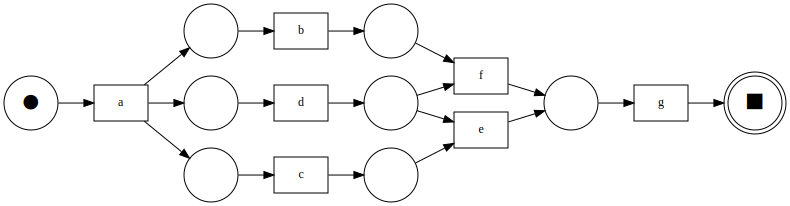

In [5]:
net, initial_marking, final_marking = alpha_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
gviz

Jeśli powyższa prosta analiza przebiegła bez zakłóceń, możemy przejść do bardziej praktycznego przykładu.

## Analiza dzienników systemu ERP

W ramach tego ćwiczenia przeanalizowany zostanie proces zakupów zarejestrowany w logach systemu ERP. W procesie bierze udział pięciu aktorów:
- Klient
- Specjalista ds. zamówień
- Agent ds. zakupów
- Dostawca
- Menedżer ds. finansów

Zlecający sygnalizują występowanie nieefektywnych transakcji, niezgodności z procedurami założonymi w firmie oraz opóźnienia na niektórych etapach procesu. Celem eksploracji będzie znalezienie odpowiedzi na poniższe pytania:
1.	Jak wygląda faktyczne wykonanie procesu zakupu? Czy widać problemy w realizacji procesu?
2.	Czy istnieją odstępstwa w wykonaniu procesu od założonego modelu procesu? Jeśli tak, to jakie?
3.	Czy spełnione są założenia i cele wydajnościowe? Czy pojedynczy zakup, od zamówienia do dostawy, trwa mniej niż 21 dni?


**Zad. 1: Wczytaj zbiór danych `log.csv` do dataframe'a. Każdy wiersz odpowiada jednemu zdarzeniu. Przyjrzyj się czego dotyczą poszczególne kolumny w logu. Upewnij się, że wsczytałeś kolumny z datą jako datetime.**

In [13]:
date_columns = ['Czas rozpoczęcia', 'Czas zakończenia']
df = pd.read_csv("log.csv", parse_dates=date_columns)

df.head(10)

,ID,Czas rozpoczęcia,Czas zakończenia,Czynność,Osoba odpowiedzialna,Rola
0,339,2011-02-16 14:31:00,2011-02-16 15:23:00,Przygotuj zamówienie,Nico Ojenbeer,Klient
1,339,2011-02-17 09:34:00,2011-02-17 09:40:00,Analizuj zamówienie,Maris Freeman,Specjalista ds. zamówień
2,339,2011-02-17 21:29:00,2011-02-17 21:52:00,Korekta zamówenia,Elvira Lores,Klient
3,339,2011-02-18 17:24:00,2011-02-18 17:30:00,Analizuj zamówienie,Heinz Gutschmidt,Specjalista ds. zamówień
4,339,2011-02-18 17:36:00,2011-02-18 17:38:00,Przygotuj zapytanie ofertowe dla specjalisty d...,Francis Odell,Specjalista ds. zamówień
5,339,2011-02-22 09:34:00,2011-02-22 09:58:00,Analizuj zapytanie ofertowe,Magdalena Predutta,Agent ds. zakupów
6,339,2011-02-22 10:50:00,2011-02-22 11:03:00,Korekta zapytania ofertowego dla klienta,Penn Osterwalder,Specjalista ds. zamówień
7,339,2011-02-28 08:10:00,2011-02-28 08:34:00,Analizuj zapytanie ofertowe,Francois de Perrier,Agent ds. zakupów
8,940,2011-05-17 06:31:00,2011-05-17 07:08:00,Przygotuj zamówienie,Immanuel Karagianni,Klient
9,940,2011-05-17 09:58:00,2011-05-17 10:06:00,Przygotuj zapytanie ofertowe dla klienta,Esmana Liubiata,Klient


**Zad. 2: Przekonwertuj zbiór danych do formatu używanego przez pm4py. Pamiętaj aby przemapować nazwy kolumn. Uwaga: czas rozpoczęcia zmapuj jako `start_timestamp`, a czas zakończenia tak jak czas w poprzednim przykładzie. Zastanów się czy sortować dane według czasu rozpoczęcia czy zakończenia. Ile przypadków wykonań zawiera zaimportowany dziennik zdarzeń?**

In [17]:
df.rename(columns={"Czas rozpoczęcia": "start_timestamp", "Czas zakończenia": "time:timestamp", "ID": "case:concept:name", "Czynność":"concept:name"}, inplace=True)
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values('time:timestamp')

print(f"df size: {len(df)}")
df.head(10)

df size: 9119


,case:concept:name,start_timestamp,time:timestamp,concept:name,Osoba odpowiedzialna,Rola
713,2,2011-01-01 00:16:00+00:00,2011-01-01 00:29:00+00:00,Przygotuj zamówienie,Immanuel Karagianni,Klient
771,1,2011-01-01 00:00:00+00:00,2011-01-01 00:37:00+00:00,Przygotuj zamówienie,Kim Passa,Klient
640,3,2011-01-01 02:23:00+00:00,2011-01-01 03:03:00+00:00,Przygotuj zamówienie,Kim Passa,Klient
772,1,2011-01-01 05:37:00+00:00,2011-01-01 05:45:00+00:00,Przygotuj zapytanie ofertowe dla klienta,Kim Passa,Klient
773,1,2011-01-01 06:41:00+00:00,2011-01-01 06:55:00+00:00,Analizuj zapytanie ofertowe,Karel de Groot,Agent ds. zakupów
714,2,2011-01-01 08:16:00+00:00,2011-01-01 08:26:00+00:00,Przygotuj zapytanie ofertowe dla klienta,Alberto Duport,Klient
937,4,2011-01-01 08:39:00+00:00,2011-01-01 09:00:00+00:00,Przygotuj zamówienie,Fjodor Kowalski,Klient
715,2,2011-01-01 09:34:00+00:00,2011-01-01 09:38:00+00:00,Analizuj zapytanie ofertowe,Karel de Groot,Agent ds. zakupów
716,2,2011-01-01 10:16:00+00:00,2011-01-01 10:21:00+00:00,Korekta zapytania ofertowego dla klienta,Christian Francois,Specjalista ds. zamówień
899,5,2011-01-01 09:49:00+00:00,2011-01-01 10:35:00+00:00,Przygotuj zamówienie,Esmana Liubiata,Klient


In [18]:
log = log_converter.apply(df)
log

[{'attributes': {'concept:name': 2}, 'events': [{'start_timestamp': Timestamp('2011-01-01 00:16:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2011-01-01 00:29:00+0000', tz='UTC'), 'concept:name': 'Przygotuj zamówienie', 'Osoba odpowiedzialna': 'Immanuel Karagianni', 'Rola': 'Klient'}, '..', {'start_timestamp': Timestamp('2011-01-06 06:21:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2011-01-06 06:32:00+0000', tz='UTC'), 'concept:name': 'Opłać fakturę', 'Osoba odpowiedzialna': 'Karalda Nimwada', 'Rola': 'Menedżer ds. finansów'}]}, '....', {'attributes': {'concept:name': 1949}, 'events': [{'start_timestamp': Timestamp('2011-10-13 06:27:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2011-10-13 07:21:00+0000', tz='UTC'), 'concept:name': 'Przygotuj zamówienie', 'Osoba odpowiedzialna': 'Tesca Lobes', 'Rola': 'Klient'}, '..', {'start_timestamp': Timestamp('2011-10-13 17:03:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2011-10-13 17:09:00+0000', tz='UTC'), 'concept:name': 'Anali

W następnym kroku zwizualizujemy proces ukryty w dziennikach zdarzeń. Jednak tym razem zamiast tworzyć sieć Petriego w pierwszej kolejności spojrzymy na diagram przejść. Diagram przejść podumowuje wszystkie wykonania za pomocą grafu na którym widać ile wykonań zawierało dane zdarzenia.

**Zad. 3: Odkryj model typu [Directly-Follows Graph](https://pm4py.fit.fraunhofer.de/documentation#item-3-4). Zwizualizuj go pokazując liczbę wystąpień każdego zdarzenia.** 

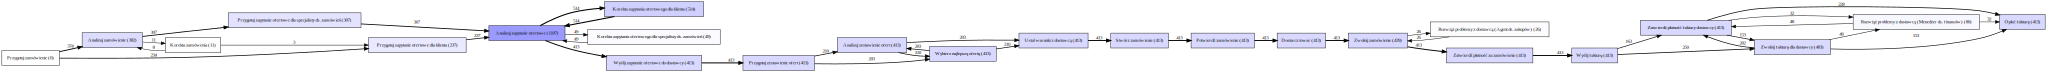

In [37]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(log)

gviz = dfg_visualization.apply(dfg)
gviz

Przyjrzyj się jak wygląda model procesu. Cyfry w prostokątach oznaczają liczbę aktywności, które wystąpiły. Cyfry na strzałkach wskazują liczbę wystąpień poszczególnych aktywności bezpośrednio po sobie.
- Wszystkie 608 instancji procesu rozpoczyna się od aktywności „Przygotuj zamówienie”
- Występuje wiele odstępstw, np. wielokrotne dokonywanie korekt dokumentów

Oprócz wizualizowania liczby wystąpień, można również pokazać czas trwania każdego zdarzenia oraz czas przejść między zdarzeniami.

**Zad. 4: Ponownie zwizualizuj model, tym razem pokazując na nim czas trwania każdego zdarzenia (`PERFORMANCE`). Wykorzystaj zmienną parameters, aby poprawnie wskazać kolumnę określającą czas rozpoczęcia zdarzenia.** 

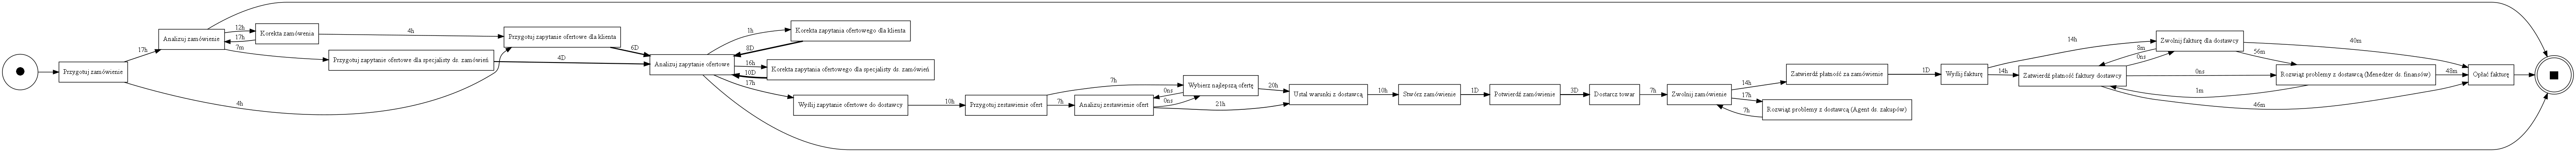

In [41]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

Zwróć uwagę, które zdarzenia trwają najdłużej. Czy któreś z nich można zoptymalizować?

Jako kolejny krok analizy, spojrzymy na statystyki procesu.

**Zad. 5: Skorzystaj z podanej niżej funkcji aby obliczyć czas trwania każdego przypadku. Zamień otrzymaną listę na pandas Series i zamień wartości z sekund na dni. Jaka była średnia długość wykonania procesu? Jaka była mediana?** 

In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics

all_case_durations = case_statistics.get_all_case_durations(log)
# ...

**Zad. 6: Narysuj histogram czasów wykonań procesu (w dniach). Czy rozkład czasu trwania przypadków odpowiada oczekiwaniom?**

## Warianty

Zwizualizowany za pomocą grafu przejść lub sieci petriego proces bierze pod uwagę i łączy wszystkie przypadki wykonań. Niemniej jednak wiele wykonań korzysta tylko z części zdarzeń w określonej kolejności. Zbiór przypadków wykonań o takim samym przebiegu nazywany jest **wariantem**. Analiza najpopularniejszych wariantów może nam sporo powiedzieć o typowych instancjach procesu.

**Zad. 7: Skorzystaj z poniższego kodu aby zwizualizować kilka najpopularniejszych wariantów. Co reprezentuje trzeci pod względem częstości wariant (index=2)? Wróć do wizualizacji całego procesu i sprawdź czy od zdarzenia *Analizuj zamówienie* istnieje jakiś bezpośredni łuk do końca procesu.** 

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
variants = variants_filter.get_variants(log)
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

def display_variant(log, variants, variants_count, index):
    variant_log = variants[variants_count[index]['variant']]
    print("Wariant {} pokrywa {:.2%} przypadków".format(index, 1.0*variants_count[index]['count']/len(log)))
                                                           
    dfg = dfg_discovery.apply(variant_log)
    gviz = dfg_visualization.apply(dfg, log=variant_log, variant=dfg_visualization.Variants.FREQUENCY)
    return gviz

Warianty mogą być wykorzystane do filtrowania danych na podstawie których odkrywany jest proces.

**Zad. 8: Skorzystaj z funkcji `pm4py.filter_variants_top_k(log, k)` aby przefiltrować log, a następnie odkryj i zwizualizuj proces na podstawie takiego ograniczonego zestawu przypadków. Powtórz to ćwiczenie korzystając z funkcji `pm4py.filter_variants_by_coverage_percentage(log, perc)`.** 

In [ ]:
# filtered_log = pm4py.filter_variants_top_k(...)

# ...

In [ ]:
# filtered_log = pm4py.filter_variants_by_coverage_percentage(...)

# ...

## Alternatywne spojrzenie

Oprócz patrzenia przez pryzmat czynności, można na ten sam proces spojrzeć pod kątem ról i aktorów.

**Zad. 9: Ponownie wczytaj dane z pliku `log.csv.` lecz tym razem jako kolumnę zdarzeń wskaż kolumnę `Rola`. Odkryj i zwizualizuj proces. Gdzie występują największe zakłócenia? Z jakim stanowiskiem związane są największe opóźnienia?** 